# Data Visualization Notebook

## Objectives

- answer business requirement
  - the client is interested to have a study to visually differentiate healty from mildew affected cherry leaves 

## Inputs

- inputs/cherryleaves_dataset/cherry-leaves/train
- inputs/cherryleaves_dataset/cherry-leaves/test
- inputs/cherryleaves_dataset/cherry-leaves/validation

## Outputs

- Image shape embeddings pickle file. 
- Mean and vairability of images per label plot. 
- Plot to distinguish the contrast between healthy and mildew infected cherry leaves. 
- Generate code that answers busines requirement 1 and can be used to build an image monatage on the Streamlit dashboard.

## Comments | Insights | Conclusions

---

# Set Data Directory

---

## Import libraries

In [2]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
import seaborn as sns 
import joblib
sns.set_style('white')
from matplotlib.image import imread

## Set working directory

In [3]:
cwd= os.getcwd()

In [4]:
os.chdir('/workspace/Detection-Cherry-Powdery-Mildew')
print("You set a new current directory")

You set a new current directory


In [5]:
work_dir = os.getcwd()
work_dir

'/workspace/Detection-Cherry-Powdery-Mildew'

## Set imput directories

Set train, validation and test paths

In [9]:
my_data_dir = 'inputs/cherryleaves_dataset/cherry-leaves'
train_path = my_data_dir + '/train' 
val_path = my_data_dir + '/validation'
test_path = my_data_dir + '/test'

## Set output directory

In [10]:
version = 'v1'
file_path = f'outputs/{version}'

if 'outputs' in os.listdir(work_dir) and version in os.listdir(work_dir + '/outputs'):
    print('Old version is already available create a new version.')
    pass
else:
    os.makedirs(name=file_path)

Old version is already available create a new version.


## Set label names

In [11]:
labels = os.listdir(train_path)
print('Label for the images are', labels)

Label for the images are ['healthy', 'powdery_mildew']


----

# Data visualization of image data

---

## Image shape

Compute average images size on train set

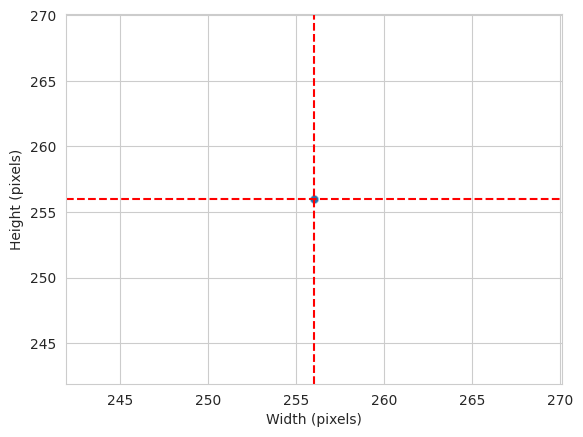

Width average: 256 
Height average: 256


In [12]:
dim1, dim2 = [], []
for label in labels:
    for image_filename in os.listdir(train_path + '/' + label):
        img = imread(train_path + '/' + label + '/' + image_filename)
        d1, d2, colors = img.shape
        dim1.append(d1)  # image height
        dim2.append(d2)  # image width

sns.set_style("whitegrid")
fig, axes = plt.subplots()
sns.scatterplot(x=dim2, y=dim1, alpha=0.2)
axes.set_xlabel("Width (pixels)")
axes.set_ylabel("Height (pixels)")
dim1_mean = int(np.array(dim1).mean())
dim2_mean = int(np.array(dim2).mean())
axes.axvline(x=dim1_mean, color='r', linestyle='--')
axes.axhline(y=dim2_mean, color='r', linestyle='--')
plt.show()
print(f"Width average: {dim2_mean} \nHeight average: {dim1_mean}")

Images size for training the model is the average from all images in the train set. 

In [13]:
image_shape = (dim1_mean, dim2_mean, 3)
image_shape

(256, 256, 3)

Save the image shape embeddings

In [14]:
joblib.dump(value=image_shape ,
            filename=f"{file_path}/image_shape.pkl")

['outputs/v1/image_shape.pkl']